**MuQing Wen, Zhouyi Qian**

Spring 2023

CS 443: Bio-inspired Machine Learning

#### Week 1: Neural decoders

# Project 1: Hebbian Learning

This week you will build two different single-layer neural networks (<b>"decoders"</b>) for supervised learning in TensorFlow:
1. linear softmax neural network — essentially the one in your MLP project from CS 343.
2. nonlinear MLP implemented in Tensorflow that uses a new activation function (hyperbolic tangent).

Next week, you will uses these decoding networks to see how accurately you can decode the class (int 0-9) from neural activations generated by a bio-inspired Hebbian neural network to each image in the MNIST handwritten dataset (this is like *"mind reading"*!). **For now, let's ignore this part** and assume that the above two neural networks that you implement will process the MNIST data directly (reshaped to the usual `(N, M)` for MLPs).

**Important notes:**
1. Your challenge is to implement `neural_decoder.py` **only with TensorFlow, no Numpy**. In other words, you should **not** import numpy at the top of `neural_decoder.py`. The reason for this is to encourage practice with the TensorFlow API.
2. Your implementation in of both networks should only use the TensorFlow low-level API (no Keras).

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

# plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.show()
plt.rcParams.update({'font.size': 18})

np.set_printoptions(suppress=True, precision=3)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 1: Linear softmax decoder

The linear decoder is a single-layer softmax network. At the implementation level there is nothing different about this network than what you built last semester. This warm-up task will allow you to practice design skills that you have developed in CS 343 and apply them to a new situation. 

**Reminder:** This network should be built using TensorFlow only (no Numpy).

In [10]:
from neural_decoder import NeuralDecoder

### 1a. Neural decoder shared functionality: basics

Start by implementing methods that both the linear and nonlinear decoders will share in the `NeuralDecoder` class (`neural_decoder.py`). Use the below test code to help you along.

- Constructor
- `get_wts(self)`
- `get_b(self)`
- `set_wts(self)`
- `set_b(self)`
- `one_hot(self, y, C, off_value=0)`
- `accuracy(self, y_true, y_pred)`

#### Test: weight and bias initialization

In [11]:
tf.random.set_seed(0)
M, C = 3, 2
nl = NeuralDecoder(M, C, wt_stdev=0.01)
wts = nl.get_wts()
b = nl.get_b()
print(f"Your wts are:\n{wts}\nand should be:")
print("""<tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
array([[ 0.015,  0.004],
       [-0.004, -0.01 ],
       [-0.012,  0.005]], dtype=float32)>""")
print(f"\nYour bias is:\n{b}\nand should be")
print("""<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([0.011, 0.002], dtype=float32)> """)

Your wts are:
<tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
array([[ 0.015,  0.004],
       [-0.004, -0.01 ],
       [-0.012,  0.005]], dtype=float32)>
and should be:
<tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
array([[ 0.015,  0.004],
       [-0.004, -0.01 ],
       [-0.012,  0.005]], dtype=float32)>

Your bias is:
<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([0.011, 0.002], dtype=float32)>
and should be
<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([0.011, 0.002], dtype=float32)> 


#### Test: one-hot

In [12]:
C = 5
y = tf.constant([0, 3, 2, 4])
nl = NeuralDecoder(1, C)
print(f'Your one-hot coding of {y} is:')
tf.print(nl.one_hot(y, C))
print('and should be:\n[[1 0 0 0 0]\n [0 0 0 1 0]\n [0 0 1 0 0]\n [0 0 0 0 1]]')

Your one-hot coding of [0 3 2 4] is:
[[1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]]
and should be:
[[1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]]


#### Test: accuracy

In [13]:
nl = NeuralDecoder(1, 1)
y1 = tf.constant([1, 2, 3, 1, 2, 3])
y2 = tf.constant([1, 0, 3, 1, 0, 3])
acc = nl.accuracy(y1, y2)
print(f'Your accuracy is {acc:.2f} and should be 0.67')

Your accuracy is 0.67 and should be 0.67


### 1b. Implement Softmax decoder

Create a class in `neural_decoder.py` called `SoftmaxDecoder` that inherits from `NeuralDecoder`. Implement and test the following methods in your `SoftmaxDecoder` class:
- `forward(self, x):` Do the follow pass with samples `x`. For the softmax network, this is Dense netIn followed by softmax netAct.
- `loss(self, yh, net_act):` Computes cross-entropy loss with true classes `yh` (one-hot coded) and `net_act`.


For cross-entropy loss, you can use the "one-hot version" of the equation (*since true class values $\vec{yh}$ are one-hot coded coming in*):

$$L = -\frac{1}{B} \sum_{i=1}^B \sum_{c=1}^C yh_{ic} \times log(\text{netAct}_{ic})$$

where $B$ is the mini-batch size and $C$ is the number of classes, like usual.

#### Tips
- If you are getting type compatibility problems, try casting to `tf.float32`.

In [14]:
from neural_decoder import SoftmaxDecoder

#### Test forward

In [15]:
N, M, C = 4, 3, 5

# test input samples
tf.random.set_seed(0)
x = tf.random.normal(shape=(N, M), dtype=tf.float32)

sm_net = SoftmaxDecoder(M, C)
sm_net.set_b(tf.constant([-0.062,  0.088, -0.148, 0.3, -0.002], dtype=tf.float32))
sm_net.set_wts(tf.constant([[-0.062,  0.112,  0.127, 0.11, 0.12], \
    [ 0.143,  0.04 ,  0.063, -0.11, -0.12], \
    [-0.22 ,  0.189, -0.017, 0.13, 0.14]], dtype=tf.float32))
test_net_act = sm_net.forward(x)

print(f'Your net_act is:\n{test_net_act}')
print(f'and it should be:')
print("""[[0.172 0.209 0.186 0.248 0.185]
 [0.151 0.201 0.138 0.292 0.217]
 [0.181 0.237 0.17  0.237 0.174]
 [0.166 0.193 0.166 0.272 0.203]]""")

Your net_act is:
[[0.172 0.209 0.186 0.248 0.185]
 [0.151 0.201 0.138 0.292 0.217]
 [0.181 0.237 0.17  0.237 0.174]
 [0.166 0.193 0.166 0.272 0.203]]
and it should be:
[[0.172 0.209 0.186 0.248 0.185]
 [0.151 0.201 0.138 0.292 0.217]
 [0.181 0.237 0.17  0.237 0.174]
 [0.166 0.193 0.166 0.272 0.203]]


#### Test loss

In [16]:
N, M, C = 4, 3, 5

# test input samples
tf.random.set_seed(0)
x = tf.random.normal(shape=(N, M), dtype=tf.float32)

sm_net = SoftmaxDecoder(M, C)
sm_net.set_b(tf.constant([-0.062,  0.088, -0.148, 0.3, -0.002], dtype=tf.float32))
sm_net.set_wts(tf.constant([[-0.062,  0.112,  0.127, 0.11, 0.12], \
    [ 0.143,  0.04 ,  0.063, -0.11, -0.12], \
    [-0.22 ,  0.189, -0.017, 0.13, 0.14]], dtype=tf.float32))
test_net_act = sm_net.forward(x)
test_yh = sm_net.one_hot(y, C)
test_loss = sm_net.loss(test_yh, test_net_act)

print(f'Your loss is {test_loss:.4f} and it should be 1.5895')

Your loss is 1.5895 and it should be 1.5895


### 1c. Neural decoder shared functionality (`predict`)

Now that you've implemented the specific methods for the softmax decoder, implement the `predict(self, x, net_act=None)` in the `NeuralDecoder` class, which predicts the class of each sample in `x`. This method is common to both the linear and nonlinear decoders (`neural_decoder.py`):

To predict the class of sample `i` $c_i^*$, you can use softmax:
$$c_i^* = argmax_{c}(\text{netAct}_{ic})$$


#### Test `predict`

In [17]:
N, M, C = 4, 3, 3

# test input samples
tf.random.set_seed(5)
x = tf.random.normal(shape=(N, M), dtype=tf.float32)

sm_net = SoftmaxDecoder(M, C)
sm_net.set_b(tf.constant([-0.062,  0.088, -0.148], dtype=tf.float32))
sm_net.set_wts(tf.constant([[-0.062,  0.112,  0.127], \
    [ 0.143,  0.04 ,  0.063], \
    [-0.22 ,  0.189, -0.017]], dtype=tf.float32))
test_preds = sm_net.predict(x)

tf.print(f'Your test predicted classes are {test_preds} and they should be [1 0 1 1]')

Your test predicted classes are [1 0 1 1] and they should be [1 0 1 1]


### 1d. Neural decoder shared functionality (`fit` with early stopping)

To make determining a reasonable number of training epochs less of a chore, implement training with **early stopping**: train and regularly monitor loss on the validation set. If the network has not "broken a new record" in making the validation loss smaller over the recent history, stop training the network. We also limit training to some maximum number of epochs in case we do not stop early to prevent the network possibly training for an unreasonably long time. The number of validation loss values in the recent history that we consider when deciding whether to stop training early is called the **patience**.

#### Todo

Implement the following training related methods in the `NeuralDecoder` class (`neural_decoder.py`). These methods are shared among all types of decoder networks (linear, nonlinear).

- `early_stopping(self, recent_val_losses, curr_val_loss, patience)`: Update rolling list of recent validation loss values with the validation loss computed on the current epoch. Return whether we should stop training based on the `patience` hyperparameter value.
- `extract_at_indices(self, x, indices)`: small helper method to return the samples or labels (`x`) at the indices `indices`. Useful for forming mini-batches during training.
- `fit(self, x, y, x_val=None, y_val=None, mini_batch_sz=512, lr=1e-4, max_epochs=1000, patience=3, val_freq=1, verbose=True)`

#### Test `early_stopping`

In [18]:
sd = SoftmaxDecoder(1, 1)

# Test 1
patience_1 = 5
es_lost_hist_1 = []
for iter in range(10):
    curr_loss = float(iter)
    es_lost_hist_1, stop = sd.early_stopping(es_lost_hist_1, curr_loss, patience=patience_1)

    if stop:
        break
print(f'Early stopping Test 1 ({patience_1=}):\n Stopped after {iter} iterations (should be 5 iterations).')
print(f' Recent loss history is {es_lost_hist_1} and should be [1.0, 2.0, 3.0, 4.0, 5.0]')
print()

# Test 2
tf.random.set_seed(1)
patience_2 = 3
es_lost_hist_2 = []
test_2_loss_vals = list(tf.random.uniform(shape=(20,)).numpy())
for iter in range(30):
    curr_loss = test_2_loss_vals[iter]
    es_lost_hist_2, stop = sd.early_stopping(es_lost_hist_2, curr_loss, patience=patience_2)

    if stop:
        break
print(f'Early stopping Test 2 ({patience_2=}):\n Stopped after {iter} iterations (should be 6 iterations).')
print(f' Recent loss history is {es_lost_hist_2} and should be [0.29193902, 0.64250207, 0.9757855]')
print()

# Test 3
tf.random.set_seed(1)
patience_3 = 6
es_lost_hist_3 = []
test_3_loss_vals = list(tf.random.uniform(shape=(20,)).numpy())
for iter in range(30):
    curr_loss = test_3_loss_vals[iter]
    es_lost_hist_3, stop = sd.early_stopping(es_lost_hist_3, curr_loss, patience=patience_3)

    if stop:
        break
print(f'Early stopping Test 3 ({patience_3=}):\n Stopped after {iter} iterations (should be 9 iterations).')
print(f' Recent loss history is\n {es_lost_hist_3}\n and should be')
print(f' [0.29193902, 0.64250207, 0.9757855, 0.43509948, 0.6601019, 0.60489583]')
print()



[1.0, 2.0, 3.0, 4.0, 5.0]
Early stopping Test 1 (patience_1=5):
 Stopped after 5 iterations (should be 5 iterations).
 Recent loss history is [1.0, 2.0, 3.0, 4.0, 5.0] and should be [1.0, 2.0, 3.0, 4.0, 5.0]

[0.9014813, 0.6309742, 0.4345461]
[0.6309742, 0.4345461, 0.29193902]
[0.4345461, 0.29193902, 0.64250207]
[0.29193902, 0.64250207, 0.9757855]
Early stopping Test 2 (patience_2=3):
 Stopped after 6 iterations (should be 6 iterations).
 Recent loss history is [0.29193902, 0.64250207, 0.9757855] and should be [0.29193902, 0.64250207, 0.9757855]

[0.9014813, 0.6309742, 0.4345461, 0.29193902, 0.64250207, 0.9757855]
[0.6309742, 0.4345461, 0.29193902, 0.64250207, 0.9757855, 0.43509948]
[0.4345461, 0.29193902, 0.64250207, 0.9757855, 0.43509948, 0.6601019]
[0.29193902, 0.64250207, 0.9757855, 0.43509948, 0.6601019, 0.60489583]
Early stopping Test 3 (patience_3=6):
 Stopped after 9 iterations (should be 9 iterations).
 Recent loss history is
 [0.29193902, 0.64250207, 0.9757855, 0.43509948, 0.

#### Test `extract_at_indices`

In [19]:
sd = SoftmaxDecoder(1, 1)

# Test 1
test_samples = tf.reshape(tf.range(100, dtype=tf.float32), [25, 4])
test_1_inds = tf.constant([0, 10, 2])
test_1_vals = sd.extract_at_indices(test_samples, test_1_inds)
print(f'Test 1:\n-------\n {test_1_vals=}\n and should be')
print(""" test_1_vals=<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[ 0.,  1.,  2.,  3.],
       [40., 41., 42., 43.],
       [ 8.,  9., 10., 11.]], dtype=float32)>""")

# Test 2
tf.random.set_seed(0)
test_labels = tf.random.shuffle(tf.range(10))
test_2_inds = tf.constant([1, 2, 3, 4])
test_2_vals = sd.extract_at_indices(test_labels, test_2_inds)
print(f'Test 2:\n-------\n {test_2_vals=}\n and should be')
print(""" test_2_vals=<tf.Tensor: shape=(4,), dtype=int32, numpy=array([9, 1, 2, 7], dtype=int32)>""")


Test 1:
-------
 test_1_vals=<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[ 0.,  1.,  2.,  3.],
       [40., 41., 42., 43.],
       [ 8.,  9., 10., 11.]], dtype=float32)>
 and should be
 test_1_vals=<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[ 0.,  1.,  2.,  3.],
       [40., 41., 42., 43.],
       [ 8.,  9., 10., 11.]], dtype=float32)>
Test 2:
-------
 test_2_vals=<tf.Tensor: shape=(4,), dtype=int32, numpy=array([9, 1, 2, 7], dtype=int32)>
 and should be
 test_2_vals=<tf.Tensor: shape=(4,), dtype=int32, numpy=array([9, 1, 2, 7], dtype=int32)>


#### Test `fit`

Write code in the cell below to:
- Load in Iris training and validation sets (as you have done above for your softmax classifier). For this test, **don't** do any preprocessing (e.g. no normalization).
- Make sure that your train and validation samples are `tf.float32`.
- Create and train a softmax decoder network using the hyperparameters provided below.
- Make a well-labeled plot showing the validation loss over training epochs.

If everything is working as expected, your validation accuracy should reach ~98% by the end of training and the validation loss should reach ~0.08. Everyone's epochs until early stopping might be different. Mine stopped after 700 epochs.

You may use Numpy as needed when writing code in this notebook.

Suggested information to include in training progress print outs (**note:** the numbers below are fake placeholders):

```
Epoch 0/4999, Training loss 10.00, Val loss 5.00, Val acc 10.00
Epoch 100/4999, Training loss 9.00, Val loss 4.00, Val acc 15.00
```

In [20]:
iris_train_labels = np.load("data/iris/iris_train_labels.npy")
iris_train_samps = np.load("data/iris/iris_train_samps.npy")
iris_val_labels = np.load("data/iris/iris_val_labels.npy")
iris_val_samps = np.load("data/iris/iris_val_samps.npy")

In [21]:
print(iris_train_labels.shape)
print(iris_train_labels)
print(iris_train_samps.shape)
print(iris_train_samps[:5])
print(iris_val_labels.shape)
print(iris_val_labels)
print(iris_val_samps.shape)
print(iris_val_samps[:5])

(100,)
[2 2 1 1 0 2 2 1 2 1 0 0 1 0 0 2 2 1 0 0 0 0 1 0 1 1 1 0 0 2 0 1 1 1 0 2 2
 1 1 0 2 0 1 2 2 2 1 1 1 2 2 1 2 2 1 2 1 0 1 1 1 1 2 1 2 0 0 2 1 0 0 1 0 2
 1 0 1 2 1 0 2 2 2 2 0 0 2 2 0 2 0 2 2 0 0 2 0 0 0 1]
(100, 4)
[[6.1 2.6 5.6 1.4]
 [6.5 3.2 5.1 2. ]
 [5.  2.  3.5 1. ]
 [5.5 2.4 3.7 1. ]
 [4.4 2.9 1.4 0.2]]
(49,)
[2 2 0 0 0 1 1 0 0 1 0 2 1 2 1 0 2 0 2 0 0 2 1 2 2 1 1 2 1 2 2 1 1 0 1 2 2
 0 1 1 1 1 0 0 0 2 1 2 0]
(49, 4)
[[6.8 3.2 5.9 2.3]
 [6.3 2.9 5.6 1.8]
 [4.9 3.  1.4 0.2]
 [5.  3.2 1.2 0.2]
 [4.7 3.2 1.6 0.2]]


In [22]:
# img = img[None, :, :, :].astype("float32")
iris_train_labels = tf.Variable(tf.identity(iris_train_labels))
iris_train_samps = tf.cast(tf.Variable(tf.identity(iris_train_samps)), dtype=tf.float32)
iris_val_labels = tf.Variable(tf.identity(iris_val_labels))
iris_val_samps = tf.cast(tf.Variable(tf.identity(iris_val_samps)), dtype=tf.float32)

In [23]:
print(iris_train_labels.dtype)
print(iris_train_samps.dtype)
print(iris_val_labels.dtype)
print(iris_val_samps.dtype)

<dtype: 'int64'>
<dtype: 'float32'>
<dtype: 'int64'>
<dtype: 'float32'>


In [24]:
tf.random.set_seed(0)  # keep me

# Use these parameters in your softmax net
mini_batch_sz = 25
lr = 1e-1
max_epochs = 5000
patience = 3
val_every = 100  # how often (in epochs) we check the val loss/acc/early stopping

# TODO: Your code here:
net_001 =  SoftmaxDecoder(num_features=4, num_classes=3, wt_stdev=0.1)

In [25]:
train_loss_hist, val_loss_hist, num_epochs = net_001.fit(iris_train_samps, iris_train_labels, x_val=iris_val_samps, y_val=iris_val_labels, mini_batch_sz=mini_batch_sz, lr=lr, max_epochs=max_epochs, patience=patience, val_every=val_every,
            verbose=True)

Starting to train network ....
Epoch 0/5000, Training Loss: 1.12, Val loss: 1.55, Val acc: 32.65%.

Epoch 100/5000, Training Loss: 0.05, Val loss: 0.09, Val acc: 97.96%.

Epoch 200/5000, Training Loss: 0.05, Val loss: 0.10, Val acc: 95.92%.

Epoch 300/5000, Training Loss: 0.11, Val loss: 0.15, Val acc: 95.92%.

[<tf.Tensor: shape=(), dtype=float32, numpy=0.089108385>, <tf.Tensor: shape=(), dtype=float32, numpy=0.10252461>, <tf.Tensor: shape=(), dtype=float32, numpy=0.15381005>]


In [26]:
def plot_loss(loss, label="val loss", title="Validation Loss", acc_freq=None, num_epoch=None, n_samps=None, batch_sz=None):
        
        x_list = []
        if (acc_freq is None) or (num_epoch is None) or (n_samps is None) or (batch_sz is None):
            x_list = list(np.arange(len(loss)))
        else:
            for i in range(len(loss)):
                iteration = (i+1)*acc_freq - 1
                i_epoch = int(iteration / (n_samps / batch_sz))
                x_list.append(i_epoch)
            
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 9))
        axes.plot(x_list, loss, 'b-', markersize=10, label=label)

        # Axes.set_xlabel(xlabel)
        axes.set_xlabel("Training Epochs")
        axes.set_ylabel("Loss")
        
        # axes.set_xticks(x_list)
        axes.set_xticklabels(axes.get_xticks(), rotation = 0)

        # frameon: Whether the legend should be drawn on a patch (frame).
        axes.legend(loc="lower left", bbox_to_anchor=(1, 0), frameon=True, edgecolor="black")

        axes.set_title(title)
        plt.show()


/var/folders/w9/cc58q4sx1_x2xvcygb70jn2w0000gp/T/ipykernel_42863/4208410992.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticks(), rotation = 0)


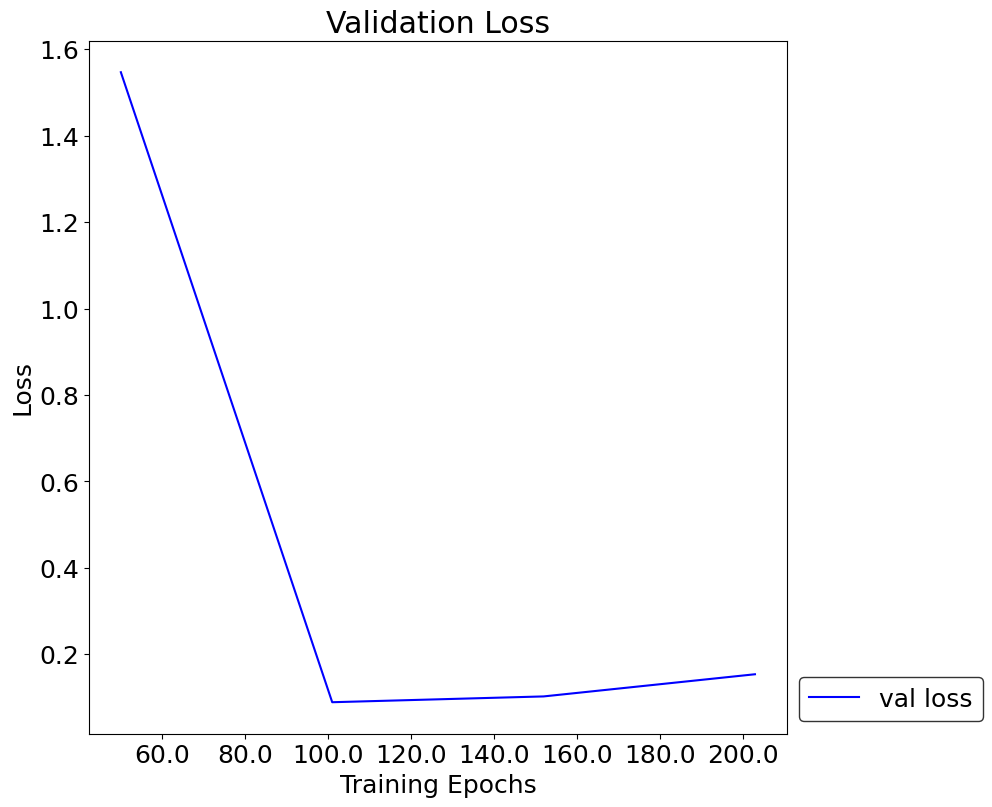

In [27]:
plot_loss(loss=val_loss_hist, acc_freq=val_every, num_epoch=num_epochs, n_samps=iris_val_samps.shape[0], batch_sz=mini_batch_sz)

### Increase Patience

In [28]:
iris_train_labels = np.load("data/iris/iris_train_labels.npy")
iris_train_samps = np.load("data/iris/iris_train_samps.npy")
iris_val_labels = np.load("data/iris/iris_val_labels.npy")
iris_val_samps = np.load("data/iris/iris_val_samps.npy")

iris_train_labels = tf.Variable(tf.identity(iris_train_labels))
iris_train_samps = tf.cast(tf.Variable(tf.identity(iris_train_samps)), dtype=tf.float32)
iris_val_labels = tf.Variable(tf.identity(iris_val_labels))
iris_val_samps = tf.cast(tf.Variable(tf.identity(iris_val_samps)), dtype=tf.float32)

tf.random.set_seed(0)  # keep me

# Use these parameters in your softmax net
mini_batch_sz = 25
lr = 1e-1
max_epochs = 5000
patience_2 = 10
val_every = 100  # how often (in epochs) we check the val loss/acc/early stopping

# TODO: Your code here:
net_002 =  SoftmaxDecoder(num_features=4, num_classes=3, wt_stdev=0.1)

In [29]:
train_loss_hist2, val_loss_hist2, num_epochs2 = net_002.fit(iris_train_samps, iris_train_labels, x_val=iris_val_samps, y_val=iris_val_labels, mini_batch_sz=mini_batch_sz, lr=lr, max_epochs=max_epochs, patience=patience_2, val_every=val_every,
            verbose=True)

Starting to train network ....
Epoch 0/5000, Training Loss: 1.12, Val loss: 1.55, Val acc: 32.65%.

Epoch 100/5000, Training Loss: 0.05, Val loss: 0.09, Val acc: 97.96%.

Epoch 200/5000, Training Loss: 0.05, Val loss: 0.10, Val acc: 95.92%.

Epoch 300/5000, Training Loss: 0.11, Val loss: 0.15, Val acc: 95.92%.

Epoch 400/5000, Training Loss: 0.07, Val loss: 0.07, Val acc: 95.92%.

Epoch 500/5000, Training Loss: 0.16, Val loss: 0.11, Val acc: 95.92%.

Epoch 600/5000, Training Loss: 0.03, Val loss: 0.09, Val acc: 95.92%.

Epoch 700/5000, Training Loss: 0.01, Val loss: 0.09, Val acc: 97.96%.

Epoch 800/5000, Training Loss: 0.01, Val loss: 0.11, Val acc: 95.92%.

Epoch 900/5000, Training Loss: 0.11, Val loss: 0.09, Val acc: 93.88%.

Epoch 1000/5000, Training Loss: 0.02, Val loss: 0.16, Val acc: 95.92%.

[<tf.Tensor: shape=(), dtype=float32, numpy=0.089108385>, <tf.Tensor: shape=(), dtype=float32, numpy=0.10252461>, <tf.Tensor: shape=(), dtype=float32, numpy=0.15381005>, <tf.Tensor: shape=(

/var/folders/w9/cc58q4sx1_x2xvcygb70jn2w0000gp/T/ipykernel_42863/4208410992.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticks(), rotation = 0)


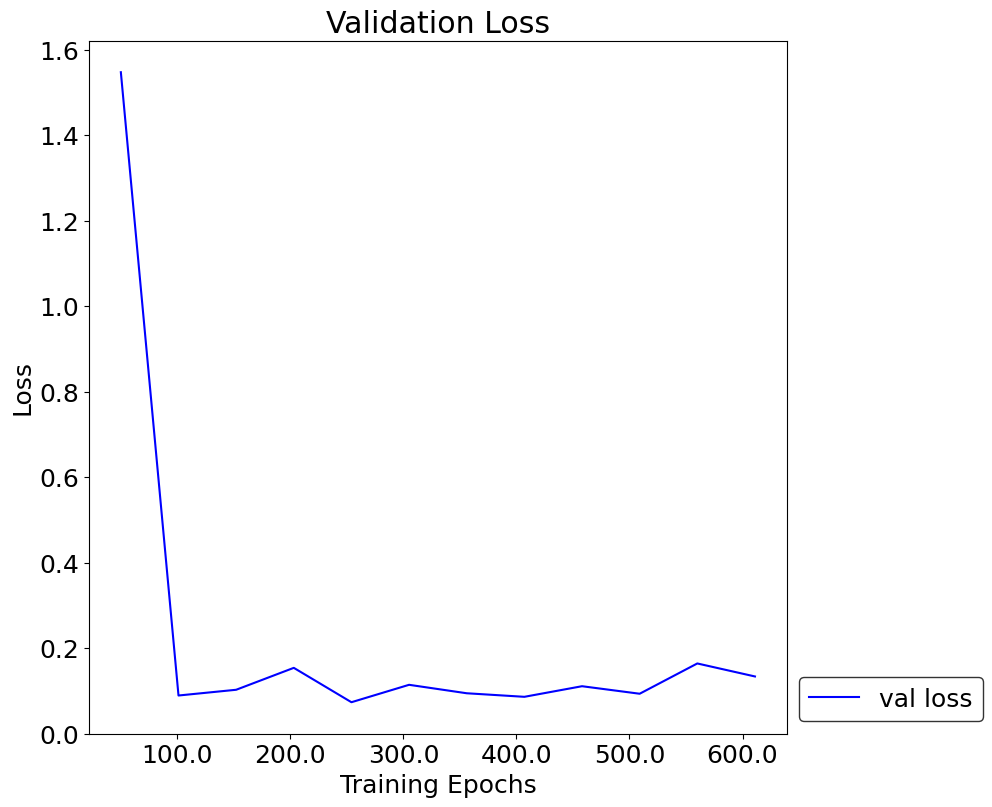

In [30]:
plot_loss(loss=val_loss_hist2, acc_freq=val_every, num_epoch=num_epochs, n_samps=iris_val_samps.shape[0], batch_sz=mini_batch_sz)

### Decrease Patience

In [31]:
iris_train_labels = np.load("data/iris/iris_train_labels.npy")
iris_train_samps = np.load("data/iris/iris_train_samps.npy")
iris_val_labels = np.load("data/iris/iris_val_labels.npy")
iris_val_samps = np.load("data/iris/iris_val_samps.npy")

iris_train_labels = tf.Variable(tf.identity(iris_train_labels))
iris_train_samps = tf.cast(tf.Variable(tf.identity(iris_train_samps)), dtype=tf.float32)
iris_val_labels = tf.Variable(tf.identity(iris_val_labels))
iris_val_samps = tf.cast(tf.Variable(tf.identity(iris_val_samps)), dtype=tf.float32)

tf.random.set_seed(0)  # keep me

# Use these parameters in your softmax net
mini_batch_sz = 25
lr = 1e-1
max_epochs = 5000
patience_3 = 2
val_every = 100  # how often (in epochs) we check the val loss/acc/early stopping

# TODO: Your code here:
net_003 =  SoftmaxDecoder(num_features=4, num_classes=3, wt_stdev=0.1)

In [32]:
train_loss_hist3, val_loss_hist3, num_epochs3 = net_003.fit(iris_train_samps, iris_train_labels, x_val=iris_val_samps, y_val=iris_val_labels, mini_batch_sz=mini_batch_sz, lr=lr, max_epochs=max_epochs, patience=patience_3, val_every=val_every,
            verbose=True)

Starting to train network ....
Epoch 0/5000, Training Loss: 1.12, Val loss: 1.55, Val acc: 32.65%.

Epoch 100/5000, Training Loss: 0.05, Val loss: 0.09, Val acc: 97.96%.

Epoch 200/5000, Training Loss: 0.05, Val loss: 0.10, Val acc: 95.92%.

[<tf.Tensor: shape=(), dtype=float32, numpy=0.089108385>, <tf.Tensor: shape=(), dtype=float32, numpy=0.10252461>]


/var/folders/w9/cc58q4sx1_x2xvcygb70jn2w0000gp/T/ipykernel_42863/4208410992.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticks(), rotation = 0)


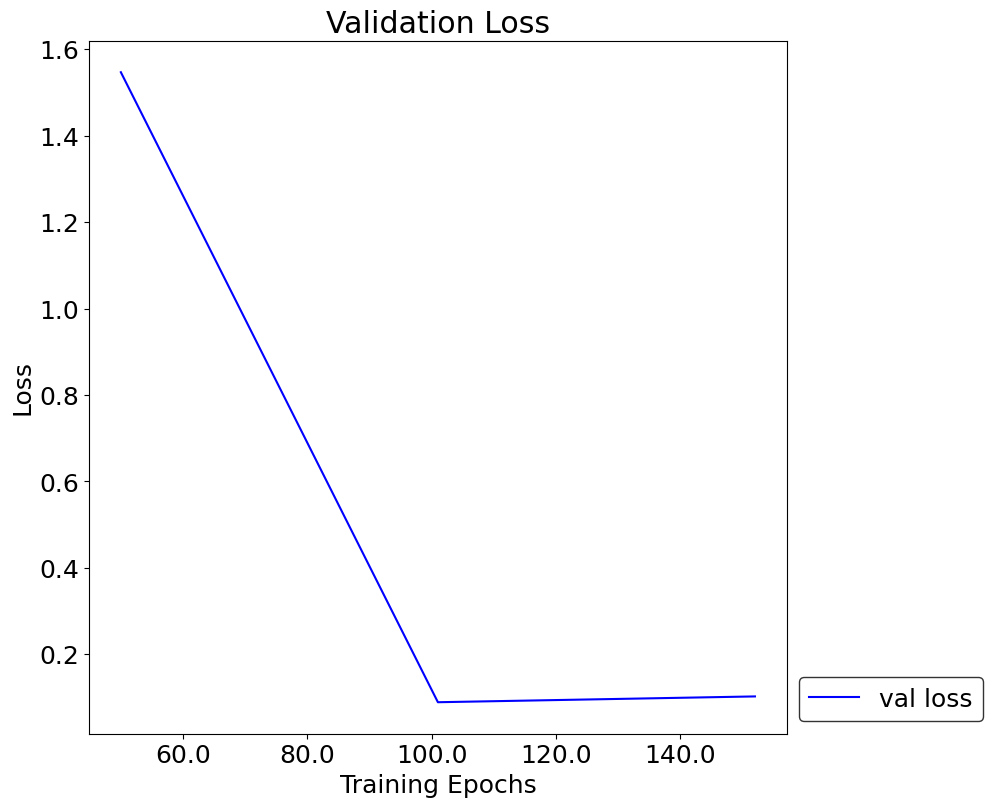

In [33]:
plot_loss(loss=val_loss_hist3, acc_freq=val_every, num_epoch=num_epochs, n_samps=iris_val_samps.shape[0], batch_sz=mini_batch_sz)

### 1e. Questions: Effect of early stopping

**Question 1:** Copy-and-paste your training code from the cell above. Change the `patience` hyperparameter. How do increases and decreases affect the duration of training and **why**?

**Question 2:** Explain how the choice of `patience` affects the risk of overfitting.

**Question 3:** For Iris, does it seem easy or hard to overfit the training set? **What makes you think so?**

**Answer 1:**
<br> When we increase the patience, the duration of the training increases.
<br> When we decrease the patience, the duration of the training decreases.
<br> This is because a large patience makes the condition to stop harder to satify: if the newest weight update can produce smaller loss, than the computation will continue.
<br> But if the patience is small, then the computation might terminate before a smaller loss value is found.

**Answer 2:**
<br> Increasing the patience increase the chance of overfitting.
<br> After a certian point, the validation loss would plateau. But there will still be slight fluctuations. If the patience is large, then we might never reach the point where the oldest validation loss (in the recent validation loss history) is smaller than all other validation losses in recent history.
<br> However, if the patience is set too small, there is also a chance of underfitting (stopping too early).

**Answer 3:**
<br> For Iris, it seem to be easy to overfit because the validation loss plateau very quickly, so there is no point running for more than 400 epochs.

## Task 2: Nonlinear decoder

Now that you have the softmax decoder implemented, implement in TensorFlow the following nonlinear single layer decoding neural network proposed by Krotov & Hopfield (2019):

$$\text{netIn}_{ic} = \sum_{j=1}^M x_{ij}w_{jc} + b_c$$
$$\text{netAct}_{ic} = tanh(\beta * \text{netIn}_{ic})$$

where:
- the `net_act` function is the hyperbolic tangent function `tanh` (*this is another common net_act function in neural networks*).
- the wts have shape `(M, C)` and the bias has shape `(C,)`.
- the input $x_{ij}$ has the usual shape `(N, M)`.

To predict the class of sample `i` $c_i^*$, use softmax (same as in your softmax network):
$$c_i^* = argmax_{c}(\text{netAct}_{ic})$$

The loss function to minimize is:

$$L = \sum_{i=1}^B \sum_{c=1}^C \left | \text{yh}_{ic} - \text{netAct}_{ic} \right |^m$$

where:
- $\text{yh}_{ic}$ is the one-hot coding of the true class of sample `i`. Remember: because we are using the $tanh$ activation function, the "on" value is `1` (like usual), **but the "off" value is `-1`**.
- The exponent `m` is a hyperparameter. By default we assume `m=6`.
- $|\cdot|$ means absolute value.

### 2a. Implement nonlinear decoder class

Make a class `NonlinearDecoder` in `neural_decoder.py` that inherits from `NeuralDecoder`. Implement the following methods in the `NonlinearDecoder` class.
- `__init__(self, num_features, num_classes, wt_stdev=0.1, beta=0.005, loss_exp=6):` Set instance variables for `beta` ($\beta$) and `loss_exp` ($m$). Extend parent class constructor/exploit inheritance. 
- `one_hot(self, y, C)`
- `forward(self, x)`
- `loss(self, yh, net_act)`

All of these methods should require only a few lines of code each.

In [34]:
from neural_decoder import NonlinearDecoder

#### Test: weight and bias initialization

In [35]:
tf.random.set_seed(1)
M, C = 4, 3
nl = NonlinearDecoder(M, C)
wts = nl.get_wts()
b = nl.get_b()

tf.print(f"Your wts are:\n{wts}\nand it should be:")
print("""<tf.Variable 'Variable:0' shape=(4, 3) dtype=float32, numpy=
array([[-0.11 ,  0.155,  0.038],
       [-0.088, -0.122, -0.098],
       [ 0.009, -0.02 , -0.056],
       [-0.072, -0.063, -0.072]], dtype=float32)>""")
tf.print(f"\nYour bias is:\n{b}\nand it should be")
print(f"<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([ 0.04 , -0.109, -0.006], dtype=float32)>")

Your wts are:
<tf.Variable 'Variable:0' shape=(4, 3) dtype=float32, numpy=
array([[-0.11 ,  0.155,  0.038],
       [-0.088, -0.122, -0.098],
       [ 0.009, -0.02 , -0.056],
       [-0.072, -0.063, -0.072]], dtype=float32)>
and it should be:
<tf.Variable 'Variable:0' shape=(4, 3) dtype=float32, numpy=
array([[-0.11 ,  0.155,  0.038],
       [-0.088, -0.122, -0.098],
       [ 0.009, -0.02 , -0.056],
       [-0.072, -0.063, -0.072]], dtype=float32)>

Your bias is:
<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([ 0.04 , -0.109, -0.006], dtype=float32)>
and it should be
<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([ 0.04 , -0.109, -0.006], dtype=float32)>


#### Test forward

In [36]:
N, M, C = 4, 3, 3

# test input samples
tf.random.set_seed(0)
x = tf.random.normal(shape=(N, M), dtype=tf.float32) + 100

nl_net = NonlinearDecoder(M, C)
nl_net.set_b(tf.constant([-0.062,  0.088, -0.148], dtype=tf.float32))
nl_net.set_wts(tf.constant([[-0.062,  0.112,  0.127], \
    [ 0.143,  0.04 ,  0.063], \
    [-0.22 ,  0.189, -0.017]], dtype=tf.float32))
test_net_act = nl_net.forward(x)

print(f'Your net_act is:\n{test_net_act}')
print(f'and it should be:')
print("""[[-0.069  0.17   0.087]
 [-0.071  0.169  0.084]
 [-0.07   0.17   0.086]
 [-0.07   0.169  0.086]]""")

Your net_act is:
[[-0.069  0.17   0.087]
 [-0.071  0.169  0.084]
 [-0.07   0.17   0.086]
 [-0.07   0.169  0.086]]
and it should be:
[[-0.069  0.17   0.087]
 [-0.071  0.169  0.084]
 [-0.07   0.17   0.086]
 [-0.07   0.169  0.086]]


#### Test loss

In [37]:
N, M, C = 4, 3, 3

# test input samples
tf.random.set_seed(0)
x = tf.random.normal(shape=(N, M), dtype=tf.float32)
y = np.array([2, 0, 1, 1])

sm_net = NonlinearDecoder(M, C)
sm_net.set_b(tf.constant([-0.062,  0.088, -0.148], dtype=tf.float32))
sm_net.set_wts(tf.constant([[-0.062,  0.112,  0.127], \
    [ 0.143,  0.04 ,  0.063], \
    [-0.22 ,  0.189, -0.017]], dtype=tf.float32))
test_yh = sm_net.one_hot(y, C)
test_net_act = sm_net.forward(x)
test_loss = sm_net.loss(test_yh, test_net_act)

print(f'Your loss is {test_loss:.4f} and it should be 11.9828')

tf.Tensor(
[[-0.     0.001  0.   ]
 [-0.001  0.001 -0.001]
 [-0.     0.001 -0.   ]
 [-0.     0.001 -0.   ]], shape=(4, 3), dtype=float32)
tf.Tensor(
[[-1. -1.  1.]
 [ 1. -1. -1.]
 [-1.  1. -1.]
 [-1.  1. -1.]], shape=(4, 3), dtype=float32)
6
Your loss is 11.9884 and it should be 11.9828


#### Test `fit`

Copy-and-paste your code from above that trains the softmax network on Iris below. Modify the code in the cell below to train your Nonlinear decoder instead and make the same plot of the validation loss.

Use the same training hyperparameters as you used with the softmax network and default values for the β and `m` (loss exponent) hyperparameters. 

If everything is working as expected, your validation accuracy should reach ~98% by the end of training and the validation loss should reach ~42. Everyone's early stopping values might be different. In case it helps to know, mine stopped after 3400 epochs.

In [38]:
tf.random.set_seed(0)  # keep me

# Use these parameters in your softmax net
mini_batch_sz = 25
lr = 1e-1
max_epochs = 5000
patience = 3
val_every = 100  # how often (in epochs) we check the val loss/acc/early stopping

# TODO: Your code here:
net_001 =  NonlinearDecoder(num_features=4, num_classes=3, wt_stdev=0.1)

Starting to train network ....
Epoch 0/5000, Training Loss: 23.71, Val loss: 46.15, Val acc: 97.96%.

Epoch 100/5000, Training Loss: 21.75, Val loss: 46.13, Val acc: 97.96%.

Epoch 200/5000, Training Loss: 26.81, Val loss: 45.39, Val acc: 97.96%.

Epoch 300/5000, Training Loss: 17.15, Val loss: 44.75, Val acc: 97.96%.

[<tf.Tensor: shape=(), dtype=float32, numpy=46.132545>, <tf.Tensor: shape=(), dtype=float32, numpy=45.39466>, <tf.Tensor: shape=(), dtype=float32, numpy=44.746185>]
Epoch 400/5000, Training Loss: 22.13, Val loss: 44.60, Val acc: 97.96%.

[<tf.Tensor: shape=(), dtype=float32, numpy=45.39466>, <tf.Tensor: shape=(), dtype=float32, numpy=44.746185>, <tf.Tensor: shape=(), dtype=float32, numpy=44.596985>]
Epoch 500/5000, Training Loss: 21.63, Val loss: 44.04, Val acc: 97.96%.

[<tf.Tensor: shape=(), dtype=float32, numpy=44.746185>, <tf.Tensor: shape=(), dtype=float32, numpy=44.596985>, <tf.Tensor: shape=(), dtype=float32, numpy=44.043587>]
Epoch 600/5000, Training Loss: 21.82,

/var/folders/w9/cc58q4sx1_x2xvcygb70jn2w0000gp/T/ipykernel_42863/4208410992.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticks(), rotation = 0)


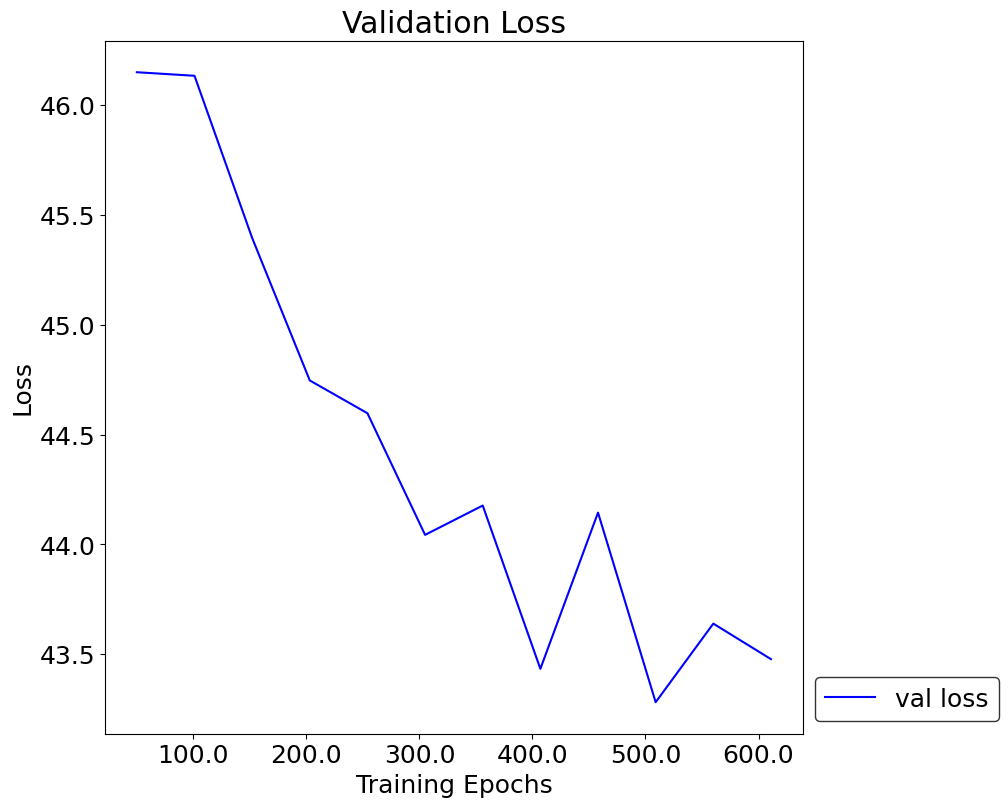

In [42]:
train_loss_hist, val_loss_hist, num_epochs = net_001.fit(iris_train_samps, iris_train_labels, x_val=iris_val_samps, y_val=iris_val_labels, mini_batch_sz=mini_batch_sz, lr=lr, max_epochs=max_epochs, patience=patience, val_every=val_every,
            verbose=True)
plot_loss(loss=val_loss_hist, acc_freq=val_every, num_epoch=num_epochs, n_samps=iris_val_samps.shape[0], batch_sz=mini_batch_sz)

### 2b. Effect of β and loss exponent

Make high-quality, well-labeled plots showing:
1. Validation loss over epoch when the nonlinear decoder loss exponent hyperparameter is: 1, 3, 6, 9. There should therefore be 4 curves plotted in the same plot (labeled with legend). Keep β at its default value.
2. Validation loss over epoch when the nonlinear decoder hyperparameter β is: 0.001, 0.005, 0.01. There should therefore be 3 curves plotted in the same plot (labeled with legend). Keep the loss exponent at its default value.

In both cases, set the remaining hyperparameters to the values used in Task 2a above except:
- Set `patience` to 2 and lower `max_epochs` (e.g. to 2000) to speed things up. For this test, it is ok if the network does not stop early (i.e. trains for the full `max_epochs` and then stops).
- Turn off `verbose` so that you do not get any print outs as each decoder is trained.

In [43]:
# Use these parameters
mini_batch_sz = 25
lr = 1e-1
max_epochs = 2000
patience = 2
val_freq = 100  # how often (in epochs) we check the val loss/acc/early stopping


In [57]:
def plot_multiple_loss(loss, labels, title="Validation Loss", acc_freq=None, num_epoch=None, n_samps=None, batch_sz=None):

        x_list = []
        if (acc_freq is None) or (num_epoch is None) or (n_samps is None) or (batch_sz is None):
            x_list = list(np.arange(len(loss)))
        else:
            for j in range(len(loss)):
                temp_x_list = []
                for i in range(len(loss[j])):
                    iteration = (i+1)*acc_freq - 1
                    i_epoch = int(iteration / (n_samps / batch_sz))
                    temp_x_list.append(i_epoch)
                x_list.append(temp_x_list)

        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 9))

        for i in range(len(x_list)):
            axes.plot(x_list[i], loss[i], 'b-', markersize=10, label=labels[i])


        # Axes.set_xlabel(xlabel)
        axes.set_xlabel("Training Epochs")
        axes.set_ylabel("Loss")

        # axes.set_xticks(x_list)
        axes.set_xticklabels(axes.get_xticks(), rotation = 0)

        # frameon: Whether the legend should be drawn on a patch (frame).
        axes.legend(loc="lower left", bbox_to_anchor=(1, 0), frameon=True, edgecolor="black")

        axes.set_title(title)
        plt.show()

In [46]:
# Effect of loss exponent m
net_001 =  NonlinearDecoder(num_features=4, num_classes=3, wt_stdev=0.1, loss_exp=1)
train_loss_hist, val_loss_hist_1, num_epochs = net_001.fit(iris_train_samps, iris_train_labels, x_val=iris_val_samps, y_val=iris_val_labels, mini_batch_sz=mini_batch_sz, lr=lr, max_epochs=max_epochs, patience=patience, val_every=val_every,
            verbose=True)
net_002 =  NonlinearDecoder(num_features=4, num_classes=3, wt_stdev=0.1, loss_exp=3)
train_loss_hist, val_loss_hist_2, num_epochs = net_002.fit(iris_train_samps, iris_train_labels, x_val=iris_val_samps, y_val=iris_val_labels, mini_batch_sz=mini_batch_sz, lr=lr, max_epochs=max_epochs, patience=patience, val_every=val_every,
            verbose=True)
net_003 =  NonlinearDecoder(num_features=4, num_classes=3, wt_stdev=0.1, loss_exp=6)
train_loss_hist, val_loss_hist_3, num_epochs = net_003.fit(iris_train_samps, iris_train_labels, x_val=iris_val_samps, y_val=iris_val_labels, mini_batch_sz=mini_batch_sz, lr=lr, max_epochs=max_epochs, patience=patience, val_every=val_every,
            verbose=True)
net_004 =  NonlinearDecoder(num_features=4, num_classes=3, wt_stdev=0.1, loss_exp=9)
train_loss_hist, val_loss_hist_4, num_epochs = net_004.fit(iris_train_samps, iris_train_labels, x_val=iris_val_samps, y_val=iris_val_labels, mini_batch_sz=mini_batch_sz, lr=lr, max_epochs=max_epochs, patience=patience, val_every=val_every,
            verbose=True)

Starting to train network ....
Epoch 0/2000, Training Loss: 75.05, Val loss: 146.73, Val acc: 32.65%.

Epoch 100/2000, Training Loss: 52.82, Val loss: 100.51, Val acc: 65.31%.

Epoch 200/2000, Training Loss: 49.03, Val loss: 89.63, Val acc: 32.65%.

Epoch 300/2000, Training Loss: 43.04, Val loss: 79.71, Val acc: 32.65%.

Epoch 400/2000, Training Loss: 37.00, Val loss: 74.59, Val acc: 32.65%.

Epoch 500/2000, Training Loss: 37.34, Val loss: 71.83, Val acc: 32.65%.

Epoch 600/2000, Training Loss: 30.82, Val loss: 70.17, Val acc: 32.65%.

Epoch 700/2000, Training Loss: 38.14, Val loss: 69.10, Val acc: 34.69%.

Epoch 800/2000, Training Loss: 35.79, Val loss: 68.37, Val acc: 34.69%.

Epoch 900/2000, Training Loss: 37.36, Val loss: 67.83, Val acc: 34.69%.

Epoch 1000/2000, Training Loss: 32.84, Val loss: 67.44, Val acc: 34.69%.

Epoch 1100/2000, Training Loss: 30.60, Val loss: 67.15, Val acc: 34.69%.

Epoch 1200/2000, Training Loss: 30.75, Val loss: 66.92, Val acc: 34.69%.

Epoch 1300/2000, 

/var/folders/w9/cc58q4sx1_x2xvcygb70jn2w0000gp/T/ipykernel_42863/373638425.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticks(), rotation = 0)


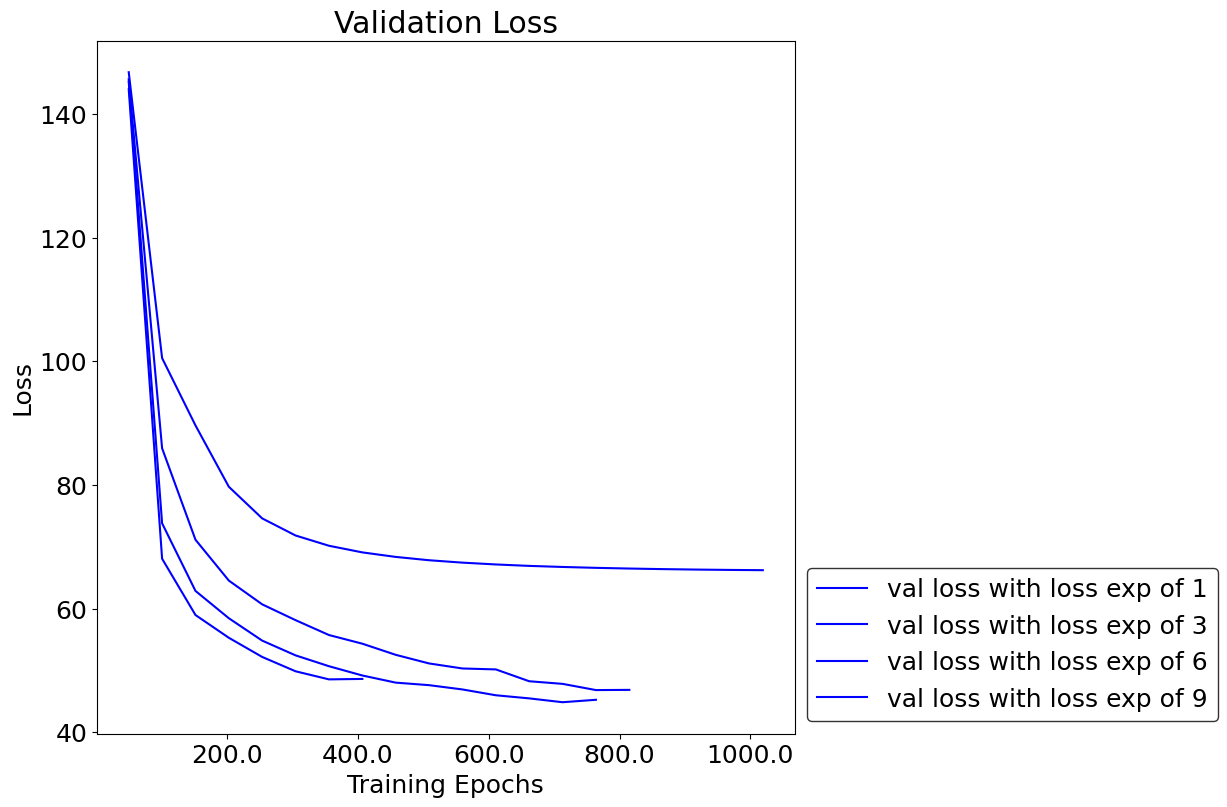

In [58]:
# Make the the plot
labels = ["val loss with loss exp of 1", "val loss with loss exp of 3", "val loss with loss exp of 6", "val loss with loss exp of 9"]
plot_multiple_loss(loss=[val_loss_hist_1,val_loss_hist_2,val_loss_hist_3,val_loss_hist_4], labels = labels, acc_freq=val_every, num_epoch=num_epochs, n_samps=iris_val_samps.shape[0], batch_sz=mini_batch_sz)

In [59]:
# Effect of beta
net_001 =  NonlinearDecoder(num_features=4, num_classes=3, wt_stdev=0.1, beta=0.001)
train_loss_hist, val_loss_hist_1, num_epochs = net_001.fit(iris_train_samps, iris_train_labels, x_val=iris_val_samps, y_val=iris_val_labels, mini_batch_sz=mini_batch_sz, lr=lr, max_epochs=max_epochs, patience=patience, val_every=val_every,
            verbose=True)
net_002 =  NonlinearDecoder(num_features=4, num_classes=3, wt_stdev=0.1, beta=0.005)
train_loss_hist, val_loss_hist_2, num_epochs = net_002.fit(iris_train_samps, iris_train_labels, x_val=iris_val_samps, y_val=iris_val_labels, mini_batch_sz=mini_batch_sz, lr=lr, max_epochs=max_epochs, patience=patience, val_every=val_every,
            verbose=True)
net_003 =  NonlinearDecoder(num_features=4, num_classes=3, wt_stdev=0.1, beta=0.01)
train_loss_hist, val_loss_hist_3, num_epochs = net_003.fit(iris_train_samps, iris_train_labels, x_val=iris_val_samps, y_val=iris_val_labels, mini_batch_sz=mini_batch_sz, lr=lr, max_epochs=max_epochs, patience=patience, val_every=val_every,
            verbose=True)


Starting to train network ....
Epoch 0/2000, Training Loss: 75.01, Val loss: 146.55, Val acc: 32.65%.

Epoch 100/2000, Training Loss: 54.61, Val loss: 109.22, Val acc: 65.31%.

Epoch 200/2000, Training Loss: 50.44, Val loss: 92.70, Val acc: 79.59%.

Epoch 300/2000, Training Loss: 44.09, Val loss: 82.92, Val acc: 71.43%.

Epoch 400/2000, Training Loss: 41.65, Val loss: 76.80, Val acc: 69.39%.

Epoch 500/2000, Training Loss: 32.93, Val loss: 72.16, Val acc: 83.67%.

Epoch 600/2000, Training Loss: 35.70, Val loss: 68.87, Val acc: 87.76%.

Epoch 700/2000, Training Loss: 34.77, Val loss: 66.91, Val acc: 79.59%.

Epoch 800/2000, Training Loss: 27.36, Val loss: 64.77, Val acc: 83.67%.

Epoch 900/2000, Training Loss: 37.55, Val loss: 62.68, Val acc: 87.76%.

Epoch 1000/2000, Training Loss: 30.00, Val loss: 61.25, Val acc: 87.76%.

Epoch 1100/2000, Training Loss: 31.05, Val loss: 59.97, Val acc: 87.76%.

Epoch 1200/2000, Training Loss: 32.67, Val loss: 58.77, Val acc: 91.84%.

Epoch 1300/2000, 

/var/folders/w9/cc58q4sx1_x2xvcygb70jn2w0000gp/T/ipykernel_42863/373638425.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticks(), rotation = 0)


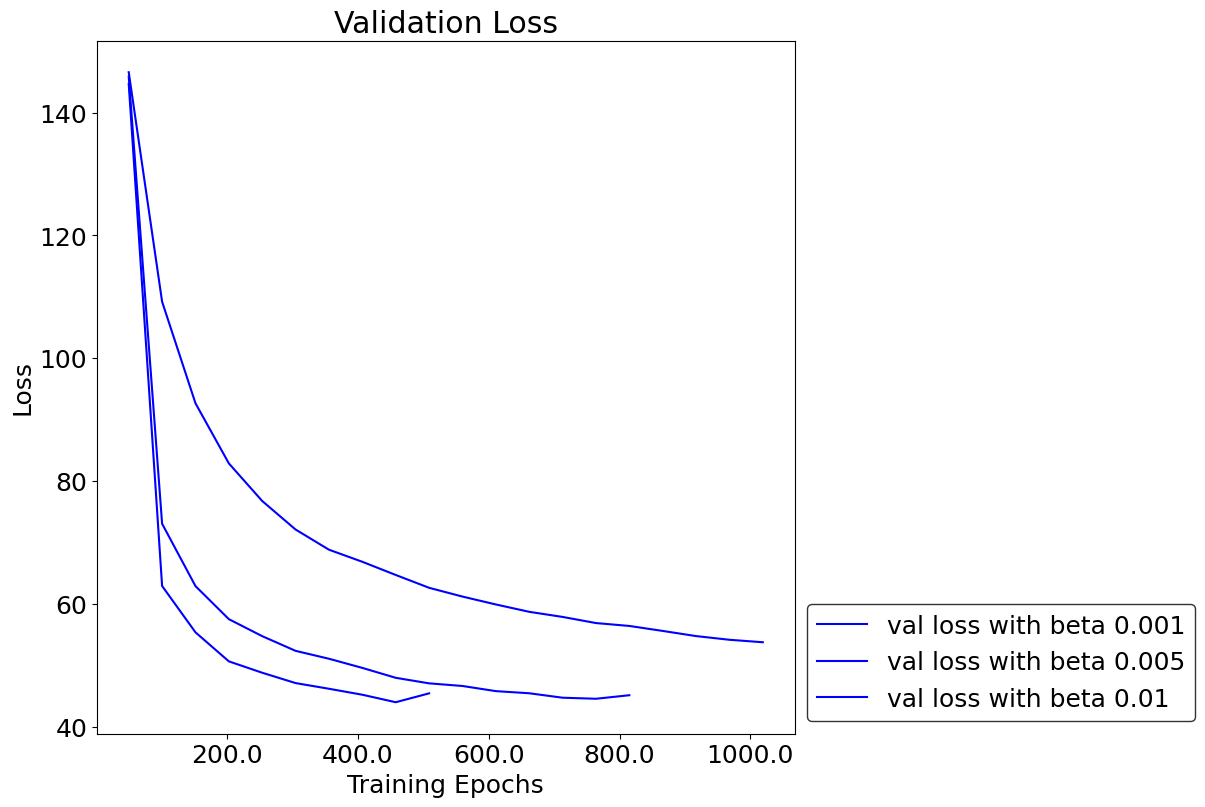

In [60]:
# Make the the plot
labels = ["val loss with beta 0.001", "val loss with beta 0.005", "val loss with beta 0.01"]
plot_multiple_loss(loss=[val_loss_hist_1,val_loss_hist_2,val_loss_hist_3], labels=labels, acc_freq=val_every, num_epoch=num_epochs, n_samps=iris_val_samps.shape[0], batch_sz=mini_batch_sz)

### 2c. Questions

**Question 4:** Explain what you observe about the effect of the loss exponent `m` on the validation loss. What does it indicate about the quality and speed of learning?

**Question 5:** Explain what you observe about the effect of β on the validation loss. What does it indicate about the quality and speed of learning?

**Answer 4:** when we increase the loss exponent, the training stops earlier since the loss are all magnified. In this case, there might be a bigger chance for the new loss to be larger than the oldest one. Setting this too high makes us terminate too early, which may affects the quality of training.

**Answer 5:** On the other hand, when we increase beta, ideally, netIn should be more close and centered to the s-curve. This creates a bigger difference between different corresponding netAct values. This may also make each netAct further away from 1 and -1 which creates a bigger loss that lead the program to stop early.